In [1]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#                  if (code_show){
#                      $('div.input').hide();
#                      } else {
#                      $('div.input').show();
#                  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>

# <form action="javascript:code_toggle()"><input type="submit" value="Показать / скрыть код"></form>''')

In [2]:
import pandas as pd
import numpy as np

import emoji
import spacy
import random
import phik
import shap
shap.initjs()

import os
import itertools
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False
from tqdm import tqdm, tqdm_notebook, tqdm_pandas

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler

from statsmodels.stats.stattools import medcouple

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
import string
import re
import natasha
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

import scipy
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna
from optuna.pruners import MedianPruner
from optuna.visualization import plot_optimization_history
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

RS = 1008

russian_alphabet = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯабвгдеёжзийклмнопрстуфхцчшщьыъэюя-'

# pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)

In [3]:
files = os.listdir(path='data/')
vk_files_list = [vk for vk in files if vk.split('_')[0] == 'vk']
tg_files_list = [tg for tg in files if tg.split('_')[0] != 'vk']

In [4]:
data = pd.concat([pd.read_csv(f'data/{df}', index_col=0)
                  .join(pd.Series(df[3:-4],
                                  index=pd.read_csv(f'data/{df}',
                                                    index_col=0)
                                  .index, name='source_group'))
                  for df in vk_files_list]).reset_index(drop=True)

data_tg = pd.concat([pd.read_csv(f'data/{df}', index_col=0)
                  for df in tg_files_list]).reset_index(drop=True)

In [5]:
data_tg = data_tg[data_tg['msg_content'] !=
                  '(File not included. Change data exporting settings to download.)']
display(data_tg.head(3))
print(data_tg.shape)
print(f"reply_to_msg_id не равно '-1': {len(data_tg[data_tg['reply_to_msg_id'] != -1])}"
 f" ({len(data_tg[data_tg['reply_to_msg_id'] != -1]) / len(data_tg):.1%})")

,sender,sender_id,reply_to_msg_id,date,msg_type,msg_content,has_mention,has_email,has_phone,has_hashtag,is_bot_command
0,НИЧЕГО СТРАШНОГО,channel1486494176,-1,2020-11-11 21:12:10,text,Проект “Ничего страшного” состоит из трех част...,0,0,0,0,0
12,НИЧЕГО СТРАШНОГО,channel1486494176,-1,2020-11-12 14:15:01,text,18 ноября | 19:00 | «Трещины» Премьера Граффи...,1,0,0,1,0
13,НИЧЕГО СТРАШНОГО,channel1486494176,-1,2020-11-12 16:06:47,text,#ПростыеРазговоры Владимир Абих @vladimir_abik...,1,0,0,1,0


(786, 11)
reply_to_msg_id не равно '-1': 75 (9.5%)


In [6]:
display(data.head(3))
print(data.shape)
print(data.info())

,date,text,is_pinned,attachments,post_source,comments,likes,reposts,views,len_text,post_source_id,year,month,dayofweek,hour,source_group
0,2022-11-03 11:06:58,"Неудобно листать стену, чтобы найти мероприяти...",1.0,1.0,vk,2,6,2.0,1575.0,167,1,2022,11,3,11,artbazar_61
1,2023-02-15 10:42:46,18 февраля в 19-30\n[club8931856|СкитЪ] предст...,0.0,1.0,vk,0,20,9.0,624.0,1350,1,2023,2,2,10,artbazar_61
2,2023-02-06 13:41:00,концерт Ильи Соболева\n \n📆 16 февраля в 19:00...,0.0,1.0,vk,0,2,2.0,372.0,138,1,2023,2,0,13,artbazar_61


(15766, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15766 entries, 0 to 15765
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            15766 non-null  object 
 1   text            12402 non-null  object 
 2   is_pinned       15766 non-null  float64
 3   attachments     15766 non-null  float64
 4   post_source     15766 non-null  object 
 5   comments        15766 non-null  int64  
 6   likes           15766 non-null  int64  
 7   reposts         15766 non-null  float64
 8   views           15766 non-null  float64
 9   len_text        15766 non-null  int64  
 10  post_source_id  15766 non-null  int64  
 11  year            15766 non-null  int64  
 12  month           15766 non-null  int64  
 13  dayofweek       15766 non-null  int64  
 14  hour            15766 non-null  int64  
 15  source_group    15766 non-null  object 
dtypes: float64(4), int64(8), object(4)
memory usage: 1.9+ MB
None


In [7]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.strftime("'%y %B")

---

In [8]:
# загрузка сохранённых признаков
saved_features = pd.read_csv('all_features.csv', sep=';', index_col=0)

data = data.join(saved_features, how='right')
for name in ['tags',
             'named_entities',
             'tokenized',
             'tok_without_names',
             'tok_without_names_unique']:
    data[name] = data[name].fillna('')

In [9]:
substr_don = '|'.join(['донскаягосударственнаяпубличнаябиблиотека',
                        'донскойгосударственнойпубличнойбиблиотеки',
                        'донскойпубличнойбиблиотеки',
                        'донскойпубличнойбиблиотеке',
                        'донскуюпубличнуюбиблитеку',
                        'донскойпубличнойбиблиотекой'])

data['tags'] = data.apply(lambda x: re.sub(f"{substr_don}", 'донскаяпубличнаябиблиотека', x['tags']), axis=1)

In [10]:
%%time
unique_words = list(set(re.sub("[\s]{2,}|^\s", "",' '.join(data['tok_without_names_unique'].tolist())).split(' ')))
unique_words.extend(['как', 'арт', 'лабас'])

data['named_entities'] = data.apply(lambda x: ' '
                                    .join([w for w in x['named_entities']
                                           .split() if w not in unique_words]), axis=1)
data['tags'] = data.apply(lambda x: ' '
                                    .join([w for w in x['tags']
                                           .split() if w not in unique_words]), axis=1)

CPU times: total: 46.2 s
Wall time: 1min 21s


In [11]:
data['nouns'] = data.apply(lambda x: x['nouns'] / len(x['tokenized'].split(' ')), axis=1)
data['verbs'] = data.apply(lambda x: x['verbs'] / len(x['tokenized'].split(' ')), axis=1)
data['adjectives'] = data.apply(lambda x: x['adjectives'] / len(x['tokenized'].split(' ')), axis=1)

----
----
----

In [12]:
features = data[['tok_without_names_unique',
                 'named_entities',
                 'tags',                 
                 'emoji_rate',
                 'exclamations_count',
                 'nouns',
                 'verbs',
                 'adjectives',
                 'mean_word_len',
                 'is_pinned',
                 'has_link',
                 'attachments',
                 'len_text',
                 'dayofweek',
                 'hour', 'named_ent_count', 'tags_count'
                 ]]

features_num_cols = ['emoji_rate', 'exclamations_count',
                 'nouns', 'verbs', 'adjectives', 'mean_word_len',
                 'attachments', 'len_text','named_ent_count', 'tags_count']
features_cat_cols = ['is_pinned', 'has_link', 'dayofweek', 'hour']
features_text_cols = ['tok_without_names_unique', 'named_entities', 'tags']

target = (data['likes'] / data['views']) * 100
target_std = np.std(target)

display(features.head(3))
display(target.head(3))

,tok_without_names_unique,named_entities,tags,emoji_rate,exclamations_count,nouns,verbs,adjectives,mean_word_len,is_pinned,has_link,attachments,len_text,dayofweek,hour,named_ent_count,tags_count
0,стена конкретный обсуждение дата найти датуафи...,,,0.000000,0,0.545455,0.272727,0.181818,8.5,1.0,1,1.0,167,3,11,0,0
1,чудо жанр ряд верба представить танец соавтор ...,,,0.000000,3,0.522124,0.115044,0.345133,7.7,0.0,0,1.0,1350,2,10,5,0
2,концерт целиноградский билет купить февраль пе...,,,0.028986,0,0.750000,0.125000,0.125000,7.9,0.0,1,1.0,138,0,13,2,0


0    0.380952
1    3.205128
2    0.537634
dtype: float64

In [13]:
X_train, X_test, y_train_likes, y_test_likes = train_test_split(features, target, test_size=.2, random_state=RS)
X_train['emoji_rate'] = X_train['emoji_rate'].fillna(0)

In [14]:
text_vectorizer = TfidfVectorizer(min_df=20, ngram_range=(1,2))
tags_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,1))
named_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,2))

X_train_text_vec = text_vectorizer.fit_transform(X_train['tok_without_names_unique'])
X_test_text_vec = text_vectorizer.transform(X_test['tok_without_names_unique'])
X_train_tags_vec = tags_vectorizer.fit_transform(X_train['tags'])
X_test_tags_vec = tags_vectorizer.transform(X_test['tags'])
X_train_named_vec = named_vectorizer.fit_transform(X_train['named_entities'])
X_test_named_vec = named_vectorizer.transform(X_test['named_entities'])

In [15]:
ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_enc = ordinal_enc.fit_transform(X_train[features_cat_cols])
X_test_enc = ordinal_enc.transform(X_test[features_cat_cols])

X_train_likes = scipy.hstack((X_train_text_vec.toarray(),
                                X_train_tags_vec.toarray(),
                                X_train_named_vec.toarray(),
                                X_train[features_num_cols],
                                X_train_enc))
X_test_likes = scipy.hstack((X_test_text_vec.toarray(),
                               X_test_tags_vec.toarray(),
                               X_test_named_vec.toarray(),
                               X_test[features_num_cols],
                               X_test_enc))

In [16]:
all_features_names_out = []
all_features_names_out.extend(text_vectorizer.get_feature_names())
all_features_names_out.extend(tags_vectorizer.get_feature_names())
all_features_names_out.extend(named_vectorizer.get_feature_names())
all_features_names_out.extend(features_num_cols)
all_features_names_out.extend(ordinal_enc.get_feature_names_out().tolist())

In [17]:
datatype = []
datatype.extend(['text' for i in text_vectorizer.get_feature_names()])
datatype.extend(['tags' for i in tags_vectorizer.get_feature_names()])
datatype.extend(['named_ent' for i in named_vectorizer.get_feature_names()])
datatype.extend(['other' for i in features_num_cols])
datatype.extend(['other' for i in ordinal_enc.get_feature_names_out().tolist()])

In [18]:
LGBM_best_RMSE = 1.179987677094565

LGBM_params = {'num_leaves': 68,
                    'learning_rate': 0.058,
                    'max_depth': 39,
                    'reg_lambda': 34,
                    'n_estimators': 137}

views_LGBM_params = {'num_leaves': 30,
                     'learning_rate': 0.052,
                     'max_depth': 40,
                     'reg_lambda': 45,
                     'n_estimators': 91}

LGBM_Regressor = LGBMRegressor(**LGBM_params,
                        random_state=RS,
                        verbose=-1)

views_LGBM_Regressor = LGBMRegressor(**views_LGBM_params,
                        random_state=RS,
                        verbose=-1)

LGBM_Regressor.fit(X_train_likes, y_train_likes)

LGBMRegressor(learning_rate=0.058, max_depth=39, n_estimators=137,
              num_leaves=68, random_state=1008, reg_lambda=34, verbose=-1)

In [19]:
importances_df = pd.DataFrame({'type_of_data': datatype,
                                'features': all_features_names_out,
                                   'importances': LGBM_Regressor.feature_importances_})

In [20]:
words_head_50 = (importances_df
                            .loc[importances_df['type_of_data'].isin(['text'])]
                            .sort_values('importances', ascending=False)
                            ).head(50)

tags_head_5 = (importances_df
                            .loc[importances_df['type_of_data'].isin(['tags'])]
                            .sort_values('importances', ascending=False)
                            ).head(5)

named_ent_head_10 = (importances_df
                            .loc[importances_df['type_of_data'].isin(['named_ent'])]
                            .sort_values('importances', ascending=False)
                            ).head(10)

other_head_n = (importances_df
                            .loc[importances_df['type_of_data'].isin(['other'])]
                            .sort_values('importances', ascending=False)
                            )

In [21]:
X_train_valuable_text = pd.DataFrame(X_train_likes[:, words_head_50.index], columns=words_head_50['features'], index=X_train.index)
X_train_valuable_tags = pd.DataFrame(X_train_likes[:, tags_head_5.index], columns=tags_head_5['features'], index=X_train.index)
X_train_valuable_othr = pd.DataFrame(X_train_likes[:, other_head_n.index], columns=other_head_n['features'], index=X_train.index)
X_test_valuable_text = pd.DataFrame(X_test_likes[:, words_head_50.index], columns=words_head_50['features'], index=X_test.index)
X_test_valuable_tags = pd.DataFrame(X_test_likes[:, tags_head_5.index], columns=tags_head_5['features'], index=X_test.index)
X_test_valuable_othr = pd.DataFrame(X_test_likes[:, other_head_n.index], columns=other_head_n['features'], index=X_test.index)
X_train_valuable_only = pd.concat([
                        X_train_valuable_text,
                        X_train_valuable_tags,
                        X_train_valuable_othr
                        ], axis=1)
X_test_valuable_only = pd.concat([
                        X_test_valuable_text,
                        X_test_valuable_tags,
                        X_test_valuable_othr
                        ], axis=1)

In [22]:
LGBM_shap_text = LGBMRegressor(**LGBM_params,
                        random_state=RS,
                        verbose=-1)
LGBM_shap_tags = LGBMRegressor(**LGBM_params,
                        random_state=RS,
                        verbose=-1)
LGBM_shap_othr = LGBMRegressor(**LGBM_params,
                        random_state=RS,
                        verbose=-1)
LGBM_shap_all = LGBMRegressor(**LGBM_params,
                        random_state=RS,
                        verbose=-1)
LGBM_shap_text.fit(X_train_valuable_text, y_train_likes)
# LGBM_shap_tags.fit(X_train_valuable_tags, y_train_likes)
# LGBM_shap_othr.fit(X_train_valuable_othr, y_train_likes)
# LGBM_shap_all.fit(X_train_valuable_only, y_train_likes)

LGBMRegressor(learning_rate=0.058, max_depth=39, n_estimators=137,
              num_leaves=68, random_state=1008, reg_lambda=34, verbose=-1)

In [23]:
background = shap.kmeans(X_train_valuable_text, 5)
# background = shap.sample(X_train_valuable_othr, 100)
shap_explainer = shap.KernelExplainer(LGBM_shap_text.predict, background)
shap_values = shap_explainer.shap_values(X_test_valuable_text)

  0%|          | 0/2071 [00:00<?, ?it/s]

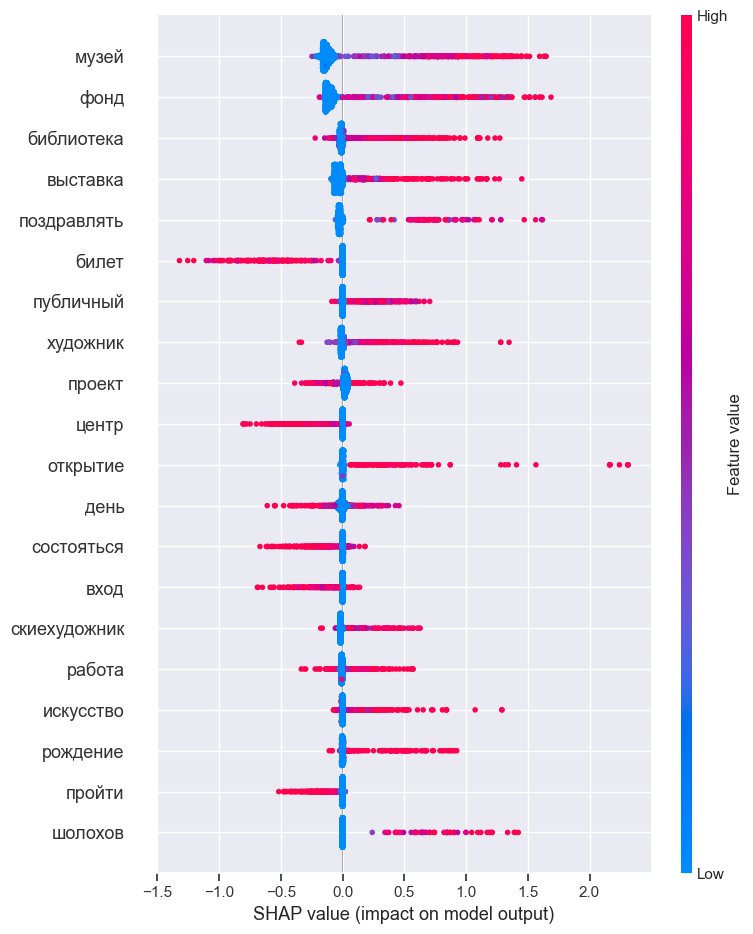

In [24]:
fig  = plt.figure()
shap.summary_plot(shap_values, X_test_valuable_text)

plt.show()
fig.savefig("d:/Data/Projects/Workshop_NLP/shap_text_summary1.png", bbox_inches='tight', dpi=300)
plt.close()

<Figure size 640x480 with 0 Axes>

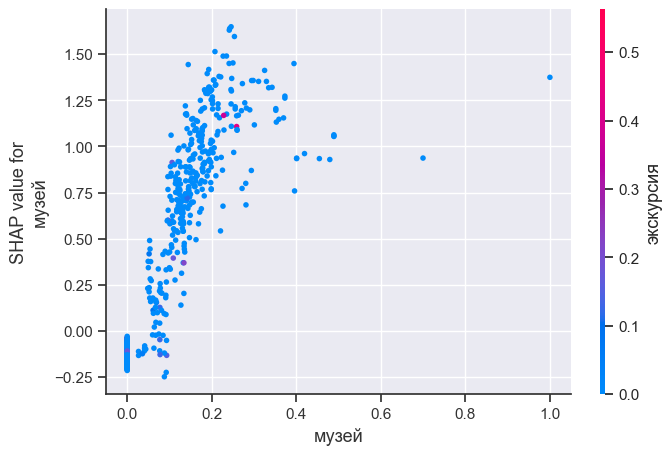

In [25]:
fig = plt.figure()
shap.dependence_plot("музей", shap_values, X_test_valuable_text, interaction_index='экскурсия')
plt.show()
# fig.savefig("d:/Data/Projects/Workshop_NLP/shap_text_features_summary1.png", bbox_inches='tight', dpi=300)
plt.close()

In [26]:
fig = plt.figure()

shap.dependence_plot("named_ent_count", shap_values, X_test_valuable_text)

plt.show()
# fig.savefig("d:/Data/Projects/Workshop_NLP/shap_text_features_summary1.png", bbox_inches='tight', dpi=300)
plt.close()

ValueError: Could not find feature named: named_ent_count

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(5):
    display(shap.force_plot(shap_explainer.expected_value, shap_values[i,:], X_test_valuable_text.iloc[i,:]))